In [12]:
from scipy import ndimage as ndi
from sklearn.preprocessing import LabelEncoder
from keras.applications import Xception
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pickle
import random

In [8]:
path = all_tile_paths[0]
img = load_img(path, target_size = (299, 299))
img = img_to_array(img)

In [21]:
img90 = ndi.rotate(img, 270)

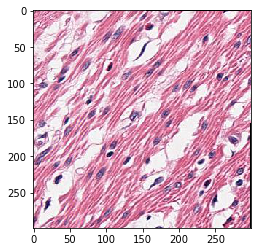

In [22]:
plt.imshow(img90.astype(np.uint8))

In [2]:
#Input Parameters
TILE_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/train_dataset_10x_02_12_19/tiles_10x')
CANCER_PATH = TILE_PATH.joinpath('cancer')
NON_CANCER_PATH = TILE_PATH.joinpath('non-cancer')
BATCH_SIZE = 128

#Output Parameters
OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/features')

In [23]:
cancer_tile_paths = [path for path in CANCER_PATH.glob('*.jpeg')]
non_cancer_tile_paths = [path for path in NON_CANCER_PATH.glob('*.jpeg')]
all_tile_paths = cancer_tile_paths + non_cancer_tile_paths
random.shuffle(all_tile_paths)

In [24]:
xception_base = Xception(weights='imagenet', include_top=False)
x = xception_base.output
features = GlobalAveragePooling2D()(x)
model = Model(inputs=xception_base.input, outputs=features)

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
total_batches = int(np.ceil(len(all_tile_paths)/BATCH_SIZE))
print(total_batches)
features_df = pd.DataFrame()

228


In [ ]:
for (batch, i) in enumerate(range(0, len(all_tile_paths), BATCH_SIZE)):
    print('processing batch {0}/{1}'.format(batch + 1, total_batches))
    batch_paths = all_tile_paths[i:i + BATCH_SIZE]
    batch_labels = [path.parent.name for path in batch_paths]
    #Duplicate each label 4 times for data augmentation
    batch_labels = [x for x in batch_labels for _ in (0,1,2,3)]
    batch_imgs = []
    for path in batch_paths:
        img = load_img(path, target_size = (299, 299))
        img = img_to_array(img)
        for angle in [0, 90, 180, 270]:
            img_rot = ndi.rotate(img, angle)
            img_rot = np.expand_dims(img_rot, axis = 0)
            img_rot = imagenet_utils.preprocess_input(img_rot)
            batch_imgs.append(img_rot)
    batch_imgs = np.vstack(batch_imgs)
    features = model.predict(batch_imgs, batch_size = BATCH_SIZE)
    features = features.reshape((features.shape[0]), 2048)
    batch_df = pd.DataFrame(features)
    batch_df['label'] = batch_labels
    features_df = pd.concat([features_df, batch_df], axis = 'index')

processing batch 1/228
processing batch 2/228
processing batch 3/228
processing batch 4/228
processing batch 5/228
processing batch 6/228
processing batch 7/228
processing batch 8/228
processing batch 9/228
processing batch 10/228
processing batch 11/228
processing batch 12/228
processing batch 13/228
processing batch 14/228
processing batch 15/228
processing batch 16/228
processing batch 17/228
processing batch 18/228
processing batch 19/228
processing batch 20/228
processing batch 21/228
processing batch 22/228
processing batch 23/228
processing batch 24/228
processing batch 25/228
processing batch 26/228
processing batch 27/228
processing batch 28/228
processing batch 29/228
processing batch 30/228
processing batch 31/228
processing batch 32/228
processing batch 33/228
processing batch 34/228
processing batch 35/228
processing batch 36/228
processing batch 37/228
processing batch 38/228
processing batch 39/228
processing batch 40/228
processing batch 41/228
processing batch 42/228
p

In [9]:
features_df.reset_index(drop = True, inplace = True)

In [10]:
features_df

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,label
0,0.000000,5.878078,0.000000,0.0,0.000000,0.000000,0.135842,0.000000,0.068097,0.000000,...,0.000000,0.277605,0.0,0.0,0.000000,0.0,0.000000,1.001070,0.000000,cancer
1,0.000000,1.134310,7.630448,0.0,0.000000,0.585219,1.725968,0.000000,2.846333,0.000000,...,0.651515,0.021600,0.0,0.0,0.000000,0.0,0.000000,2.063413,0.000000,cancer
2,0.000000,1.061499,0.000000,0.0,0.000000,0.061457,0.462785,0.000000,0.000000,0.000000,...,0.049169,0.809391,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,non-cancer
3,0.000000,2.247305,0.000000,0.0,0.000000,0.002337,0.033633,0.000000,0.000000,0.000000,...,0.030947,0.238555,0.0,0.0,0.000000,0.0,0.000000,1.151081,0.000000,non-cancer
4,0.000000,1.492867,0.640722,0.0,0.000000,0.721783,1.523534,0.000000,0.976771,0.000000,...,0.000000,0.730104,0.0,0.0,0.000000,0.0,0.000000,0.235231,0.000000,non-cancer
5,0.000000,2.621302,0.000000,0.0,0.000000,0.127392,0.265274,0.000000,0.000000,0.000000,...,0.005602,0.014508,0.0,0.0,0.000000,0.0,0.000000,1.337989,0.008232,non-cancer
6,0.000000,5.767525,0.000000,0.0,0.000000,0.000000,0.913078,0.000000,0.941549,0.000000,...,0.000000,0.721326,0.0,0.0,0.000000,0.0,0.000000,1.634909,0.000000,cancer
7,0.000000,0.657286,0.108034,0.0,0.000000,0.119886,0.077776,0.000000,0.000000,0.000000,...,0.003688,0.352029,0.0,0.0,0.056899,0.0,0.000000,0.251370,0.000000,non-cancer
8,0.000000,3.415632,0.000000,0.0,0.000000,0.162519,1.713043,0.000000,0.163458,0.000000,...,0.000000,0.381914,0.0,0.0,0.000000,0.0,0.000000,0.130546,0.000000,non-cancer
9,0.000000,1.741932,0.201029,0.0,0.000000,0.000000,1.823585,0.000000,0.000000,0.000000,...,0.000000,0.195531,0.0,0.0,0.000000,0.0,0.000000,0.768036,0.000000,cancer


In [11]:
features_df.to_csv(OUTPUT_PATH.joinpath('Xception_train_augmented_features.csv'))